In [13]:
# Import Packages

# Preprocessing
import pandas as pd
import numpy as np
import _pickle as pickle
import nltk
import nltk as nlp
from sklearn.preprocessing import LabelEncoder
from keras.preprocessing.text import Tokenizer
from keras.preprocessing import sequence
import re

# Visualization / Data Exploration
import seaborn as sns
import matplotlib.pyplot as plt

# Modeling (LSTM)
from keras.models import Model, Sequential
from keras.layers import LSTM, Activation, Dense, Dropout, Input, Embedding, BatchNormalization
from keras.optimizers import RMSprop
from keras.callbacks import EarlyStopping

# Model Validation
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score

# Load data from Pickle file
with open('./models/data/data.pickle', 'rb') as f:
    data = pickle.load(f)
    
true = data['true']
fake = data['fake']

fake['target'] = 'fake'
true['target'] = 'true'
df = pd.concat([fake, true]).reset_index(drop = True)
df.head()

,title,text,subject,date,target
0,Donald Trump Sends Out Embarrassing New Year’...,Donald Trump just couldn t wish all Americans ...,News,"December 31, 2017",fake
1,Drunk Bragging Trump Staffer Started Russian ...,House Intelligence Committee Chairman Devin Nu...,News,"December 31, 2017",fake
2,Sheriff David Clarke Becomes An Internet Joke...,"On Friday, it was revealed that former Milwauk...",News,"December 30, 2017",fake
3,Trump Is So Obsessed He Even Has Obama’s Name...,"On Christmas day, Donald Trump announced that ...",News,"December 29, 2017",fake
4,Pope Francis Just Called Out Donald Trump Dur...,Pope Francis used his annual Christmas Day mes...,News,"December 25, 2017",fake


In [2]:
df.isnull().sum() # Data is complete
print('Number of datapoints: {}'.format(len(df)))

Number of datapoints: 44898


In [3]:
# gather needed daata
X = df[['title', 'text', 'subject']]
Y = df.target

# Transform Target into binary categorical vars
# 0 if fake 1 if not fake

encoder = LabelEncoder()
Y = encoder.fit_transform(Y)
Y = pd.DataFrame(Y.reshape(-1,1), columns=['target'])

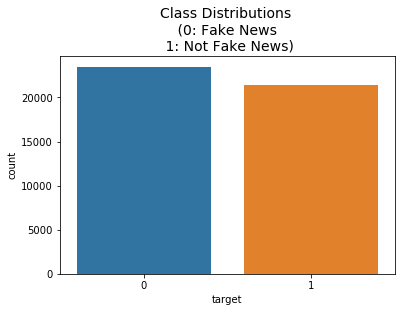

In [4]:
sns.countplot('target', data=Y)

plt.title('Class Distributions \n (0: Fake News \n 1: Not Fake News)', fontsize=14)
plt.show()

[Text(0, 0, 'politicsNews'),
 Text(0, 0, 'worldnews'),
 Text(0, 0, 'News'),
 Text(0, 0, 'politics'),
 Text(0, 0, 'left-news'),
 Text(0, 0, 'Government News'),
 Text(0, 0, 'US_News'),
 Text(0, 0, 'Middle-east')]

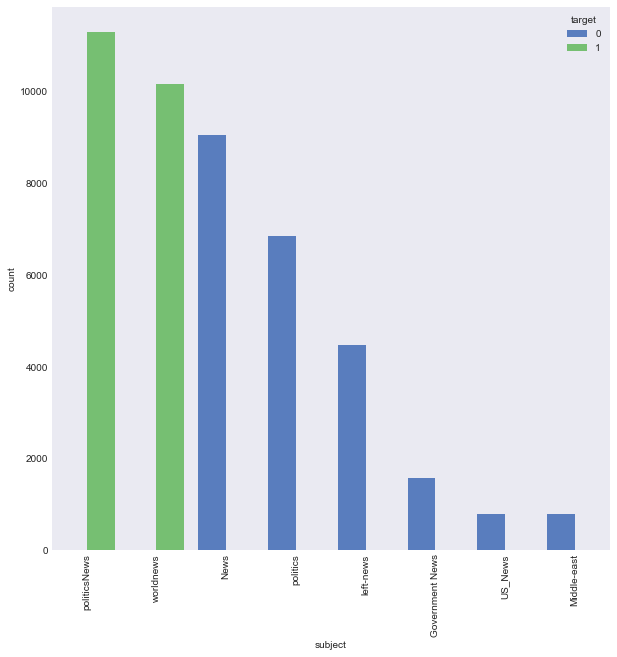

In [5]:
# Distribution of Fake News depending on Subject

plt.figure(figsize = (10,10))
sns.set_style("dark")
chart = sns.countplot(x = X["subject"], 
                      hue = Y['target'],
                      palette = 'muted',
                      order = X['subject'].value_counts().index)

chart.set_xticklabels(chart.get_xticklabels(),rotation=90)

** From the plot above, we can see that our data is somewhat biased in terms of subject. <br>
If the subject is politicsNews or worldnews then our data it is fake, hence we would not use this
variable when modeling **

In [6]:
X = df[['title', 'text']]
X['news'] = X['title'] + " " + X['text']
X.drop(['title', 'text'], axis=1, inplace=True)

C:\Users\Edric\Anaconda3\lib\site-packages\ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  
C:\Users\Edric\Anaconda3\lib\site-packages\pandas\core\frame.py:3940: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


In [7]:
# Preproc
X['news'] = X['news'].apply((lambda y:re.sub("http://\S+"," ", y)))
X['news'] = X['news'].apply((lambda x:re.sub("\@", " ",x.lower())))

C:\Users\Edric\Anaconda3\lib\site-packages\ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  
C:\Users\Edric\Anaconda3\lib\site-packages\ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  This is separate from the ipykernel package so we can avoid doing imports until


In [8]:
# Split our data, 85 % goes to training and validation (hyperparam tuning), 15% goes to model testing
X_train, X_test, Y_train, Y_test = train_test_split(X.news,
                                                    Y.target,
                                                    test_size=0.15,
                                                    random_state=0)

# Modeling:
- Logistic Regression
- LSTM Neural netowrk Model

In [9]:
from sklearn.pipeline import Pipeline
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.linear_model import LogisticRegression
import joblib


pipe = Pipeline([('vect', CountVectorizer()),
                 ('tfidf', TfidfTransformer()),
                 ('model', LogisticRegression())])

Logistic_model = pipe.fit(X_train, Y_train)
prediction = Logistic_model.predict(X_test)
print("accuracy: {}%".format(round(accuracy_score(Y_test, prediction)*100,2)))

accuracy: 98.87%


In [10]:
# joblib.dump(Logistic_model, './models/Logistic_model.sav')

In [11]:
max_len=175
max_words = 700

# Create tokenizer
tok = Tokenizer(num_words=max_words)
tok.fit_on_texts(X_train)
# Fit to train
sequences = tok.texts_to_sequences(X_train)
train_padded = sequence.pad_sequences(sequences, maxlen=max_len)

sequences = tok.texts_to_sequences(X_test)
test_padded = sequence.pad_sequences(sequences, maxlen=max_len)

In [12]:
# Save tokenizer to pickle
with open('./models/tok.pickle', 'wb') as f:
    pickle.dump(tok, f)

In [19]:
#Defining Neural Network
model = Sequential()
#Non-trainable embeddidng layer
model.add(Embedding(max_words, 32,input_length= max_len))
model.add(LSTM(64, dropout=0.1))
model.add(Dense(1, activation='sigmoid'))
model.summary()

Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_3 (Embedding)      (None, 175, 32)           22400     
_________________________________________________________________
lstm_4 (LSTM)                (None, 64)                24832     
_________________________________________________________________
dense_2 (Dense)              (None, 1)                 65        
Total params: 47,297
Trainable params: 47,297
Non-trainable params: 0
_________________________________________________________________


In [20]:
opt = RMSprop(learning_rate=0.01,
              epsilon=1e-7)

model.compile(optimizer = opt,
              loss='binary_crossentropy',
              metrics=['accuracy'])

In [23]:
# Train

callbacks = [
             EarlyStopping(monitor='val_loss',
                           patience=2,
                           min_delta=1e-3,
                           restore_best_weights=True,
                           verbose = 1)
            ]


batch_size = 256
epochs = 100
validation_split = 0.3
verbose = 1 # Print output

# Fit to training Data
history = model.fit(train_padded,
                    Y_train,
                    batch_size = batch_size,
                    epochs = epochs,
                    validation_split = validation_split,
                    callbacks = callbacks,
                    verbose = verbose)

Train on 26714 samples, validate on 11449 samples
Epoch 1/100
26714/26714 [==============================] - 30s 1ms/step - loss: 0.0393 - accuracy: 0.9869 - val_loss: 0.0317 - val_accuracy: 0.9886
Epoch 2/100
26714/26714 [==============================] - 28s 1ms/step - loss: 0.0266 - accuracy: 0.9911 - val_loss: 0.0297 - val_accuracy: 0.9907
Epoch 3/100
26714/26714 [==============================] - 27s 993us/step - loss: 0.0213 - accuracy: 0.9932 - val_loss: 0.0280 - val_accuracy: 0.9910
Epoch 4/100
26714/26714 [==============================] - 26s 960us/step - loss: 0.0169 - accuracy: 0.9945 - val_loss: 0.0272 - val_accuracy: 0.9914
Epoch 5/100
26714/26714 [==============================] - 41s 2ms/step - loss: 0.0141 - accuracy: 0.9953 - val_loss: 0.0285 - val_accuracy: 0.9912
Restoring model weights from the end of the best epoch
Epoch 00005: early stopping


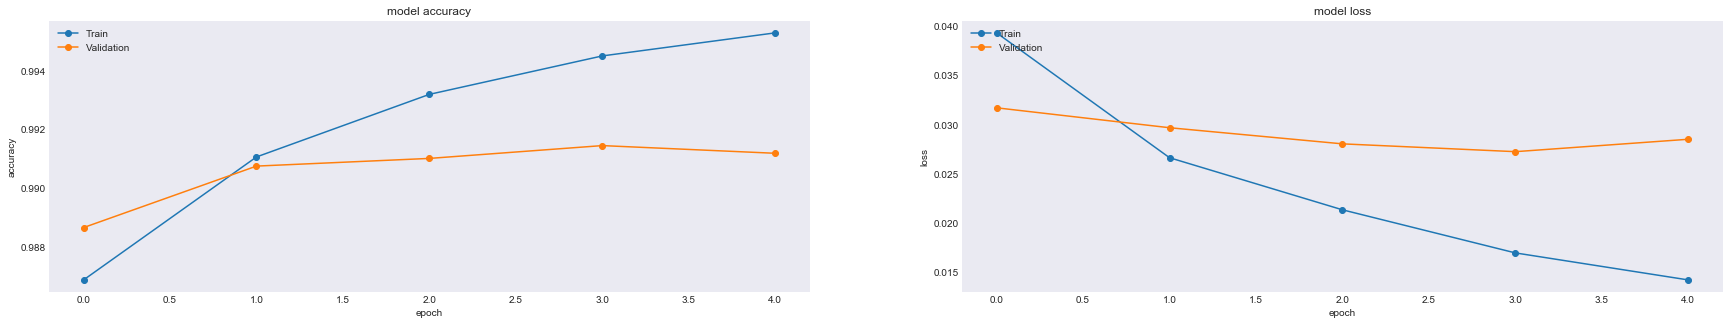

In [25]:
f, (ax1, ax2) = plt.subplots(1, 2, figsize=(30,5))

# summarize history for accuracy
ax1.plot(history.history['accuracy'], marker='o')
ax1.plot(history.history['val_accuracy'], marker='o')
ax1.set_title('model accuracy')
ax1.set_ylabel('accuracy')
ax1.set_xlabel('epoch')
ax1.legend(['Train', 'Validation'], loc='upper left')

# summarize history for loss
ax2.plot(history.history['loss'], marker='o')
ax2.plot(history.history['val_loss'], marker='o')
ax2.set_title('model loss')
ax2.set_ylabel('loss')
ax2.set_xlabel('epoch')
ax2.legend(['Train', 'Validation'], loc='upper left')

In [26]:
accr = model.evaluate(test_padded, Y_test)
print('Accuracy: {:0.2f}'.format(accr[1]))

6735/6735 [==============================] - 18s 3ms/step
Accuracy: 0.99


In [17]:
# Save LSTM model
model.save('./models/LSTM.h5')

In [29]:
from keras.models import load_model

model = load_model('./models/LSTM.h5')
model.predict_classes(test_padded)[0]

C:\Users\Edric\AppData\Roaming\Python\Python36\site-packages\tensorflow_core\python\framework\indexed_slices.py:424: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "


array([1])

In [30]:
fake_news=['This is a sample of fake news']
with open('./models/tok.pickle', 'rb') as handle:
	tok = pickle.load(handle)

In [31]:
max_len = 175
sequences = tok.texts_to_sequences(fake_news)
test_padded = sequence.pad_sequences(sequences, maxlen=max_len)
model.predict_classes(test_padded)[0][0]

0